# LSTM

In [31]:
import numpy as np
import pandas as pd
import pickle

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import nltk

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Embedding, SimpleRNN
from keras.callbacks import EarlyStopping
from keras.models import load_model

import tensorflow as tf

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import roc_auc_score,roc_curve,auc

import sys 
sys.path.append("../")
import text

In [10]:
# This bit of configuration magic is required by some GPUs and not others.
# this assumes there is only one gpu, change accordingly if you have more
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if  len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    assert tf.config.experimental.get_memory_growth(physical_devices[0]) == True
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
# porter_stemmer = PorterStemmer()
# stop_words=list(text.stop_words())
# def stem_tokenizer(text):
#     words=[porter_stemmer.stem(token) for token in word_tokenize(text.lower())]
#     return " ".join([w for w in words if w not in stop_words])

# messages=EmailInfo["body"]
# for i in range(len(messages)):
#     messages[i]=stem_tokenizer(str(messages[i]))
#     if i%10000==0:
#         print("{} done.".format(i))
    
# messages

import pandas as pd

messages=pd.read_csv("../message_body_stem.csv",index_col=[0])
messages=messages["body"]
messages

0        b'user id enrondlr\npw bnaweb22\n\n\n -- -- -o...
1        b'\nhi chri \n\ntonight roll new report curren...
2        b'rika r new \n\n -- -- -origin messag -- -- -...
3        b'john/gerald \n\nwe current trade gtc spot co...
4        b'gerald staci -\n\nattach worksheet new maste...
                               ...                        
85198    b'www.loveinfashion.com\r\nusername=custom pas...
85199    b'www.loveinfashion.com\r\nusername=custom pas...
85200    b'www.loveinfashion.com\r\nusername=custom pas...
85201    b'www.loveinfashion.com\r\nusername=custom pas...
85202    b'www.loveinfashion.com\r\nusername=custom pas...
Name: body, Length: 85203, dtype: object

78848

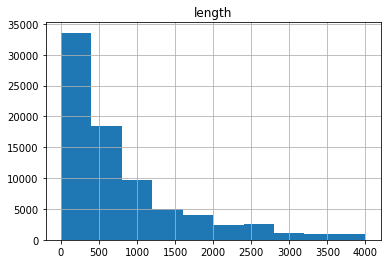

In [12]:
%matplotlib inline
lens=[]
for mes in messages:
    if len(mes)<4000:
        lens.append(len(mes))
lens=pd.DataFrame({"length":lens})
lens.hist()
len(lens)

In [13]:
max_vocab=600000
max_len=2000

tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(messages)
sequences = tokenizer.texts_to_sequences(messages)
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=max_len)

with open("./message_feature/vectokenizer.p","wb") as f:
    pickle.dump(tokenizer,f)

EmailInfo=pd.read_csv("../email_05.csv")
labels05=pd.get_dummies(EmailInfo["spam"]).values

# Test Data

In [14]:
email06=pd.read_csv("../email_06.csv")
labels06=pd.get_dummies(email06["spam"]).values

In [15]:
# porter_stemmer = PorterStemmer()
# stop_words=list(text.stop_words())

# def stem_tokenizer(text):
#     words=[porter_stemmer.stem(token) for token in word_tokenize(text.lower())]
#     return " ".join([w for w in words if w not in stop_words])

# messages=email06["body"]#len(messages)
# for i in range(len(messages)):
#     messages[i]=stem_tokenizer(str(messages[i]))
#     if i%10000==0:
#         print("{} done.".format(i))

# messages=messages.to_csv("../message_body_stem06.csv")

In [16]:
messages=pd.read_csv("../message_body_stem06.csv",index_col=[0],header=None,names=["body"])
messages=messages["body"]
messages

0        b'the mail list queri week ago and\nrun also s...
1        b \n \n luxuri watch buy rolex 219 \n \n rolex...
2        b '' academ qualif avail prestigi non-acc redi...
3        b'greet verifi subscript plan9-fans\nlist char...
4        b'tri chauncey may confer lusciou continu tons...
                               ...                        
35283    b'great news expec ted \n\ninfinex ventur inc....
35284    b'the oil sector go crazi weekli gift \n\nget ...
35285    b '' http //vdtobj.docscan.info/ 23759301\n\ns...
35286    b '' u n v e r p l s\n\ndo want prosper futur ...
35287    b'but moat coveral cytochemistri planeload sal...
Name: body, Length: 35288, dtype: object

33062

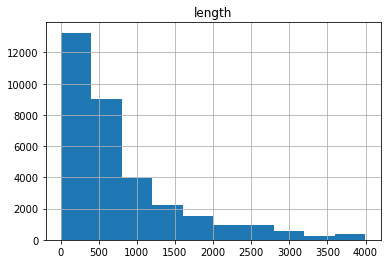

In [17]:
%matplotlib inline
lens=[]
for mes in messages:
    if len(mes)<4000:
        lens.append(len(mes))
lens=pd.DataFrame({"length":lens})
lens.hist()
len(lens)

In [18]:
with open("./message_feature/vectokenizer.p","rb") as f:
    tokenizer=pickle.load(f)

sequences = tokenizer.texts_to_sequences(messages)
word_index = tokenizer.word_index
data06 = pad_sequences(sequences, maxlen=max_len)

# model

In [19]:
import pickle
import datetime
import time

%matplotlib inline

import sys
sys.path.append("../")
from notebook_utils import get_logger,LoggingCallback

# helper routing to log a message with time
def log_message( label_string ):
    ts = time.time()
    st = datetime.datetime.fromtimestamp( ts ).strftime( '%Y-%m-%d %H:%M:%S:%f' )
    print("{}: {}".format(st, label_string))
    with open("training_log.txt","a") as f:
        f.write("{}: {}\n".format(st, label_string))

def auroc(y_true, y_pred):
    return tf.compat.v1.py_func(roc_auc_score, (y_true, y_pred), tf.double)

def LSTM_train(x_train, y_train, x_val, y_val, embedding_mat_columns,name):
    
    model = Sequential()
    model.add(Embedding(input_dim=max_vocab,output_dim=embedding_mat_columns,input_length=max_len))
    model.add(LSTM(units=embedding_mat_columns,return_sequences=True))
    model.add(LSTM(units=embedding_mat_columns))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc', auroc])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode="min", verbose=2, restore_best_weights=True)
    result=model.fit(x_train, y_train, epochs=100, batch_size=batchsize, validation_data=(x_val, y_val), 
                     callbacks=[early_stopping,LoggingCallback(3,logger)])
    
    model.save("./models/LSTM_model_{}.format(name)")
    
    with open("./models/LSTM_result_{}.p".format(name),"wb") as f:
        pickle.dump(result.history,f)

def train_all(model,x_train,y_train,x_test,y_test,embedding_mat_columns,name):
    log_message( "start" )
    model(x_train,y_train,x_test,y_test,embedding_mat_columns,name)
    log_message( "end" )

In [20]:
x_train=data
y_train=labels05
x_test=data06
y_test=labels06
np.mean(y_test,axis=0),np.mean(y_train,axis=0)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((85203, 2000), (85203, 2), (35288, 2000), (35288, 2))

In [ ]:
batchsize=128
name="message_body_1"
logger=get_logger("LSTM_{}.log".format(name))
train_all(LSTM_train,x_train,y_train,x_test,y_test,embedding_mat_columns=128,name=name)

2020-04-26 02:50:10:313321: start


/home/jb4360/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 85203 samples, validate on 35288 samples
Epoch 1/100
85203/85203 [==============================] - 2853s 33ms/step - loss: 0.2974 - acc: 0.8674 - auroc: 0.9374 - val_loss: 0.3577 - val_acc: 0.8656 - val_auroc: 0.9131
2020-04-26 03:37:45|	0: TRAIN loss 0.29742207  ||  VAL loss 0.35768166
Epoch 2/100
85203/85203 [==============================] - 2829s 33ms/step - loss: 0.1590 - acc: 0.9507 - auroc: 0.9752 - val_loss: 0.4734 - val_acc: 0.8331 - val_auroc: 0.9073
Epoch 3/100
85203/85203 [==============================] - 2890s 34ms/step - loss: 0.1396 - acc: 0.9545 - auroc: 0.9822 - val_loss: 0.3782 - val_acc: 0.8416 - val_auroc: 0.9098
Epoch 4/100
  128/85203 [..............................] - ETA: 45:15 - loss: 0.0887 - acc: 0.9688 - auroc: 0.9968

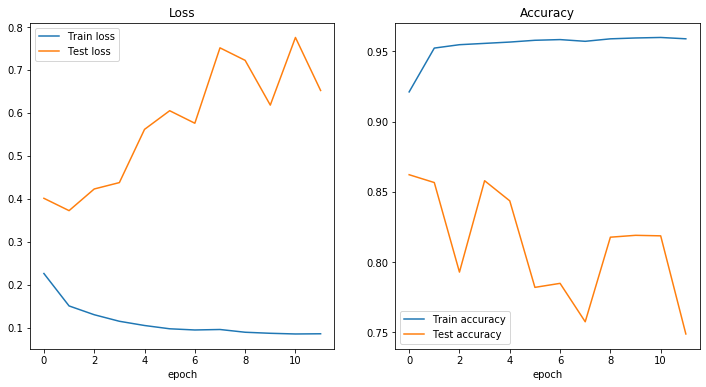

In [48]:
import matplotlib.pyplot as plt

def auroc(y_true, y_pred):
    return tf.compat.v1.py_func(roc_auc_score, (y_true, y_pred), tf.double)

with open("./models/LSTM_result_{}.p".format(name),"rb") as f:
    result=pickle.load(f)
    
# model_name = "./models/LSTM_model_{}".format(name)
# model = load_model(name, custom_objects={'auroc': auroc})

history=result
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history["loss"],label="Train loss")
plt.plot(history["val_loss"],label="Test loss")
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["acc"],label="Train accuracy")
plt.plot(history["val_acc"],label="Test accuracy")
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()

In [22]:
def auroc(y_true, y_pred):
    return tf.compat.v1.py_func(roc_auc_score, (y_true, y_pred), tf.double)

name="message_body_1"
model_name = "./models/LSTM_model_{}"
model = load_model(model_name, custom_objects={'auroc': auroc})

y_pred=model.predict(x_test)

/home/jb4360/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


<Figure size 432x288 with 0 Axes>

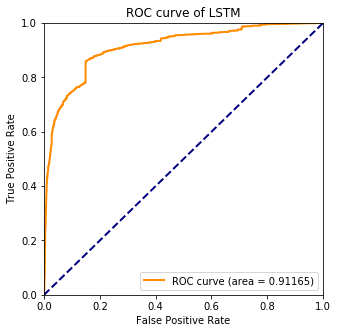

In [32]:
import matplotlib.pyplot as plt

fpr,tpr,threshold = roc_curve(y_test[:,1],y_pred[:,1])
roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of LSTM')
plt.legend(loc="lower right")
plt.savefig("roc_curve_LSTM.png")
plt.show()